#**Import The Required Libraries**

In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import image_dataset_from_directory, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.optimizers import Adam
#from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os # getting path
import glob
import sys
np.set_printoptions(threshold=sys.maxsize)

In [42]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='talk', style="ticks", rc=custom_params)

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [45]:
# Set the path to dataset:
path = 'For CNN'
train_path = path+"/Dataset"
validation_path = path+"/Dataset"
#test_path = path+"/Test"

## Data Exploration

##Images Preprocessing - Image Data Generator

In [46]:
# Loading the data into training subset 
train_ds = image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  class_names = ['WithoutMask', 'WithMask', 'MaskWearedIncorrect'], 
  label_mode = 'categorical',
  seed=22,
#  image_size=img_size,
#  batch_size=batch_size
)

# loading the data into validation subset
validation_ds = image_dataset_from_directory(
  validation_path,
  validation_split=0.2,
  subset="validation",
  class_names = ['WithoutMask', 'WithMask', 'MaskWearedIncorrect'], 
  label_mode = 'categorical',
  seed=22,
#  image_size=img_size,
#  batch_size=batch_size
)

# Preparing test dataset from part of validation subset
test_ds = validation_ds.take(5)
validation_ds = validation_ds.skip(5)

Found 3029 files belonging to 3 classes.
Using 2424 files for training.
Found 3029 files belonging to 3 classes.
Using 605 files for validation.


(32, 256, 256, 3) (32, 3)
[24, 31, 8, 9, 2, 1, 23, 17]
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


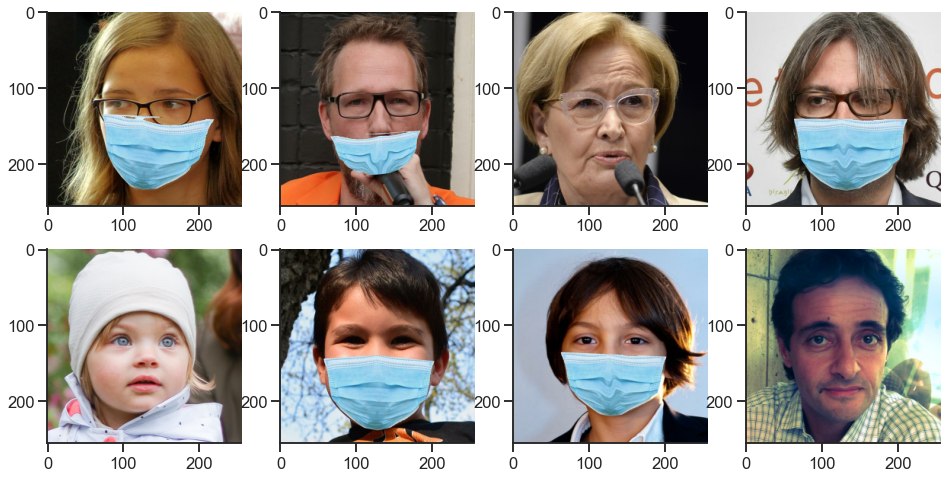

In [47]:
#Check out test_ds
import PIL
from PIL import Image

batched_iter = test_ds.__iter__()

next_batch = next(batched_iter)
next_batch_data = next_batch[0]
next_batch_label = next_batch[1]
print(next_batch_data.shape, next_batch_label.shape)

fig,ax = plt.subplots(2,4, figsize=[16,8])
idx = [i for i in np.random.randint(0,next_batch_data.shape[0],8)]
print(idx)
for i in range(4):
    ax[0][i].imshow(next_batch_data[idx[i]]/255.)
    print(next_batch_label[idx[i]])
    ax[1][i].imshow(next_batch_data[idx[i+4]]/255.)
    print(next_batch_label[idx[i+4]])

In [48]:
# Extract test images and labels
def extract_images(test_ds):
  x_test = []
  y_test = []
  for x, y in test_ds.unbatch():
    x_test.append(x.numpy())
    y_test.append(y.numpy())

  x_test = np.array(x_test)
  y_test = np.array(y_test)
  
  return x_test, y_test

In [49]:
x_test, y_test = extract_images(test_ds)

In [51]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0

# CNN model

In [52]:
# CNN
input_dim = (256, 256, 3)
cnn_model = Sequential()
cnn_model.add(Rescaling(1./255, input_shape=input_dim))
cnn_model.add(RandomFlip('horizontal'))
cnn_model.add(RandomRotation(0.2))
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_dim))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)       

In [54]:
# image batch size and labels
for img, lb in train_ds:
    print(img.shape)
    print(lb.shape)
    break
    
# image batch size and labels
for img, lb in validation_ds:
    print(img.shape)
    print(lb.shape)
    break

# image batch size and labels
for img, lb in test_ds:
    print(img.shape)
    print(lb.shape)
    break

(32, 256, 256, 3)
(32, 3)
(32, 256, 256, 3)
(32, 3)
(32, 256, 256, 3)
(32, 3)


In [55]:
history_cnn = cnn_model.fit(train_ds, validation_data=validation_ds, epochs=11)

Epoch 1/11
76/76 [==============================] - 4s 42ms/step - loss: 0.8466 - accuracy: 0.7409 - val_loss: 0.1977 - val_accuracy: 0.9416
Epoch 2/11
76/76 [==============================] - 3s 41ms/step - loss: 0.2444 - accuracy: 0.9278 - val_loss: 0.1321 - val_accuracy: 0.9551
Epoch 3/11
76/76 [==============================] - 4s 46ms/step - loss: 0.2221 - accuracy: 0.9274 - val_loss: 0.0966 - val_accuracy: 0.9640
Epoch 4/11
76/76 [==============================] - 3s 41ms/step - loss: 0.1912 - accuracy: 0.9381 - val_loss: 0.1125 - val_accuracy: 0.9663
Epoch 5/11
76/76 [==============================] - 3s 41ms/step - loss: 0.1726 - accuracy: 0.9476 - val_loss: 0.1495 - val_accuracy: 0.9393
Epoch 6/11
76/76 [==============================] - 3s 44ms/step - loss: 0.1533 - accuracy: 0.9497 - val_loss: 0.0906 - val_accuracy: 0.9618
Epoch 7/11
76/76 [==============================] - 3s 42ms/step - loss: 0.1256 - accuracy: 0.9587 - val_loss: 0.1195 - val_accuracy: 0.9551
Epoch 8/11
76

In [56]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='talk', style="ticks", rc=custom_params)

In [57]:
# Plot accuracy and loss
def history_plot(history_cnn):
  custom_params = {"axes.spines.right": False, "axes.spines.top": False}
  sns.set_theme(context='talk', style="ticks", rc=custom_params)
  fig = plt.figure(figsize=(10, 6))
  plt.plot(history_cnn.history['accuracy'])
  plt.plot(history_cnn.history['val_accuracy'])
  plt.title('Model Accuracy', y=1.05)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'lower right')
  plt.grid(linestyle='-', linewidth=0.5)
  #plt.ylim([0.6, 1]); 
  plt.ylim(top=1)
  plt.xlim([0, 11])
  plt.show()

def loss_plot(history_cnn):
  custom_params = {"axes.spines.right": False, "axes.spines.top": False}
  sns.set_theme(context='talk', style="ticks", rc=custom_params)
  fig = plt.figure(figsize=(10, 6))
  plt.plot(history_cnn.history['loss'])
  plt.plot(history_cnn.history['val_loss'])
  plt.title('Model Loss', y=1.05)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')
  plt.grid(linestyle='-', linewidth=0.5)
  #plt.ylim([0, 1]); 
  plt.xlim([0, 11])
  plt.show()

In [58]:
'upper left', 'lower left', 'lower right'

('upper left', 'lower left', 'lower right')

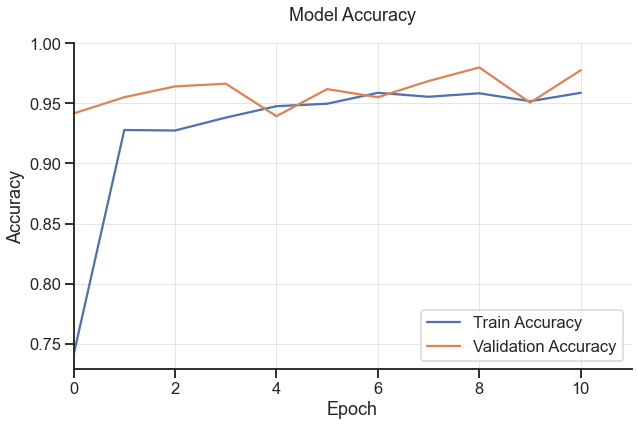

In [59]:
history_plot(history_cnn)

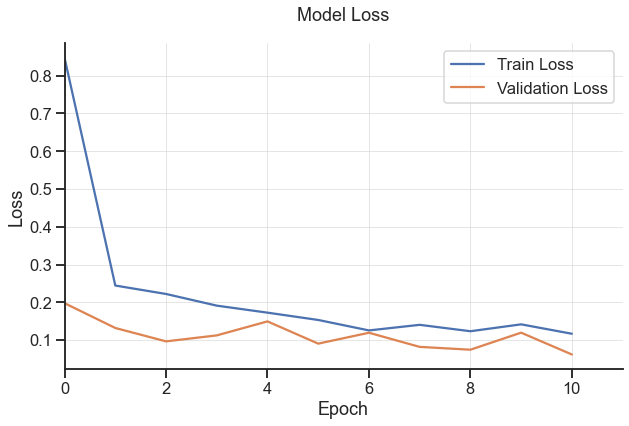

In [60]:
loss_plot(history_cnn)

## Evaluation

In [61]:
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
from imblearn.metrics import specificity_score, sensitivity_score
from sklearn.preprocessing import label_binarize

In [62]:
# Function to calculate the classification metrics: Accuracy, Sensitivity, Specificity, 
# Confusion matrix, and Classification report
def classification_metrics(y_test_pred, y_test, model_name):
    # Test accuracy
    test_accur = accuracy_score(y_test, y_test_pred)
    
    precision = precision_score(y_test, y_test_pred , average="macro")
    recall = recall_score(y_test, y_test_pred , average="macro")
    f_score = f1_score(y_test, y_test_pred , average="macro")
    #roc_auc = roc_auc_score(y_test, y_test_pred)
    labels = [0, 1, 2]
    for_roc_y_test = label_binarize(y_test, classes=labels)
    for_roc_y_test_pred = label_binarize(y_test_pred, classes=labels)
    #roc_auc = roc_auc_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(for_roc_y_test, for_roc_y_test_pred, average="macro", multi_class='ovo')
    model = {'Model': model_name,
             'Test Accuracy': test_accur,
             'Precision':precision,
             'Recall':recall, 
             'f_score':f_score,
             'ROC_AUC':roc_auc}
    model_df = pd.DataFrame(model, index=[0])
    #display(NB_model_df)
    
    print("\nTest accuracy of {}: {:.3f}".format(model_name, test_accur))
    print("\nPrecision Score of {}: {:.3f}".format(model_name, precision))
    print("\nRecall Score of {}: {:.3f}".format(model_name, recall))
    print("\nf_score {}: {:.3f}".format(model_name, f_score))
    print("\nThe roc_auc of {}: {:.3f}".format(model_name, roc_auc))

    # Classification report
    print("\nClassification report:\n\n", classification_report(y_test,y_test_pred,target_names=['No Mask', 'Masked', 'MaskWearedIncorrect']))
    print('Summary of classification metrics:')
    display(model_df)
    return model_df


#sns.set_theme(style="white", palette=None)
def confusion_matrix_plot(y_test, y_pred):
  sns.set_theme(context='talk', style="ticks")
  cm = confusion_matrix(y_test, y_pred)
  ConfusionMatrixDisplay(cm, display_labels=['No Mask', 'Masked', 'Incorrect']).plot()
  plt.title('Confusion Matrix',y = 1.05)


In [64]:
cnn_model_evaluate = cnn_model.evaluate(test_ds)

5/5 [==============================] - 0s 49ms/step - loss: 0.0536 - accuracy: 0.9875


In [65]:
def transform(x):
  if x[0] >= x[1] and x[0] >= x[2]:
    return 0
  elif x[0] <= x[1] and x[1] >= x[2]:
    return 1
  else:
    return 2


#x_test, y_test
y_pred_cnn = cnn_model.predict(x_test)
y_pred_cnn = np.apply_along_axis(transform, 1, y_pred_cnn)

In [66]:
y_pred_cnn

array([1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1,
       2, 0, 1, 0, 0, 1, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2, 2, 1, 0, 2, 1, 0,
       1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2,
       1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 1,
       2, 0, 2, 1, 0, 0, 1, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1,
       2, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 0, 2,
       0, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 0, 0, 2, 1, 2, 2,
       0, 1, 1, 1, 2, 2])

In [67]:
y_test = np.apply_along_axis(transform, 1, y_test)

In [68]:
y_test

array([1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1,
       2, 0, 1, 0, 0, 1, 2, 1, 2, 2, 2, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1, 0,
       1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2,
       1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 1,
       2, 0, 2, 2, 0, 0, 1, 2, 1, 0, 1, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2,
       2, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 0, 2,
       0, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 0, 0, 2, 1, 2, 2,
       0, 1, 1, 1, 2, 2])

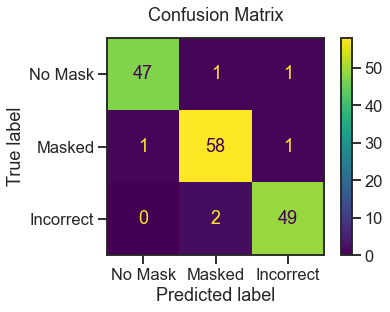

In [69]:
# Confusion Matrix
confusion_matrix_plot(y_test, y_pred_cnn)

In [70]:
CNN_model_df = classification_metrics(y_pred_cnn, y_test, model_name = 'CNN Model')


Test accuracy of CNN Model: 0.963

Precision Score of CNN Model: 0.964

Recall Score of CNN Model: 0.962

f_score CNN Model: 0.963

The roc_auc of CNN Model: 0.972

Classification report:

                      precision    recall  f1-score   support

            No Mask       0.98      0.96      0.97        49
             Masked       0.95      0.97      0.96        60
MaskWearedIncorrect       0.96      0.96      0.96        51

           accuracy                           0.96       160
          macro avg       0.96      0.96      0.96       160
       weighted avg       0.96      0.96      0.96       160

Summary of classification metrics:


Model  Test Accuracy  Precision    Recall   f_score   ROC_AUC
0  CNN Model         0.9625    0.96359  0.962212  0.962845  0.971546

In [71]:
# Save the Model
cnn_model.save("For CNN/Outputs/cnn_model.h5")


# Transfer learning with VGG19

In [72]:
# Data augmentation
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
])

In [73]:
# Instantiate base model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling='avg')

In [74]:
# Freeze the pre-trained parameters
base_model.trainable = False

In [75]:
inputs = Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)
vgg_model = keras.Model(inputs, outputs)

vgg_model.compile(optimizer=Adam(learning_rate=0.001/10), loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539  

In [77]:
init_epochs = 11
history_vgg = vgg_model.fit(train_ds, validation_data=validation_ds, epochs=init_epochs)

Epoch 1/11
76/76 [==============================] - 13s 133ms/step - loss: 3.1267 - accuracy: 0.3346 - val_loss: 2.5301 - val_accuracy: 0.3888
Epoch 2/11
76/76 [==============================] - 6s 83ms/step - loss: 2.6638 - accuracy: 0.3622 - val_loss: 2.0016 - val_accuracy: 0.4315
Epoch 3/11
76/76 [==============================] - 6s 79ms/step - loss: 2.2400 - accuracy: 0.4183 - val_loss: 1.5800 - val_accuracy: 0.5101
Epoch 4/11
76/76 [==============================] - 6s 83ms/step - loss: 1.9400 - accuracy: 0.4501 - val_loss: 1.3264 - val_accuracy: 0.5685
Epoch 5/11
76/76 [==============================] - 7s 88ms/step - loss: 1.6933 - accuracy: 0.4955 - val_loss: 1.0983 - val_accuracy: 0.6157
Epoch 6/11
76/76 [==============================] - 7s 86ms/step - loss: 1.5368 - accuracy: 0.5256 - val_loss: 0.9252 - val_accuracy: 0.6719
Epoch 7/11
76/76 [==============================] - 6s 81ms/step - loss: 1.3773 - accuracy: 0.5590 - val_loss: 0.7299 - val_accuracy: 0.7281
Epoch 8/11


In [78]:
vgg_model.evaluate(test_ds)

5/5 [==============================] - 1s 67ms/step - loss: 0.4763 - accuracy: 0.8313


[0.4762590527534485, 0.831250011920929]

Fine-tune

In [79]:
# Unfreeze base model
base_model.trainable = True

In [80]:
# Check layers
len(base_model.layers)

23

In [81]:
# Fine tune from this layer onwards
fine_tune_at = 20

In [82]:
# Freeze all layers before first fine tune layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [83]:
# Re-compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.001/100), loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539  

In [85]:
fine_tune_epochs = 11
total_epochs =  init_epochs + fine_tune_epochs

history_vggfine = vgg_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_vgg.epoch[-1],
                         validation_data=validation_ds)

Epoch 11/22
76/76 [==============================] - 7s 86ms/step - loss: 0.7285 - accuracy: 0.7372 - val_loss: 0.2061 - val_accuracy: 0.9213
Epoch 12/22
76/76 [==============================] - 6s 81ms/step - loss: 0.5056 - accuracy: 0.8226 - val_loss: 0.1580 - val_accuracy: 0.9348
Epoch 13/22
76/76 [==============================] - 6s 83ms/step - loss: 0.3599 - accuracy: 0.8705 - val_loss: 0.0814 - val_accuracy: 0.9663
Epoch 14/22
76/76 [==============================] - 6s 84ms/step - loss: 0.2768 - accuracy: 0.8977 - val_loss: 0.1018 - val_accuracy: 0.9596
Epoch 15/22
76/76 [==============================] - 6s 84ms/step - loss: 0.2582 - accuracy: 0.9047 - val_loss: 0.0722 - val_accuracy: 0.9663
Epoch 16/22
76/76 [==============================] - 6s 83ms/step - loss: 0.2250 - accuracy: 0.9241 - val_loss: 0.0612 - val_accuracy: 0.9753
Epoch 17/22
76/76 [==============================] - 6s 82ms/step - loss: 0.1969 - accuracy: 0.9323 - val_loss: 0.0420 - val_accuracy: 0.9798
Epoch 

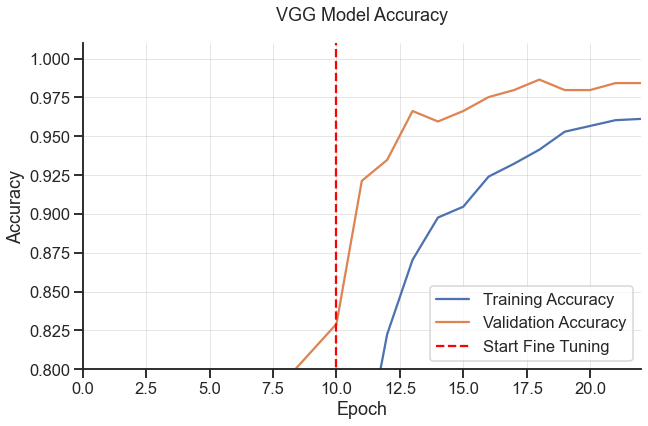

In [86]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='talk', style="ticks", rc=custom_params)


fig = plt.figure(figsize=(10, 6))
plt.plot(history_vgg.history['accuracy'] + history_vggfine.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'] + history_vggfine.history['val_accuracy'], label='Validation Accuracy')

plt.plot([init_epochs-1,init_epochs-1], plt.ylim(), label='Start Fine Tuning',color='red',linestyle='dashed')
plt.legend(loc='lower right')
plt.title('VGG Model Accuracy', y=1.05)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(linestyle='-', linewidth=0.5)
plt.ylim([0.8, 1.01]); plt.xlim([0, 22]);

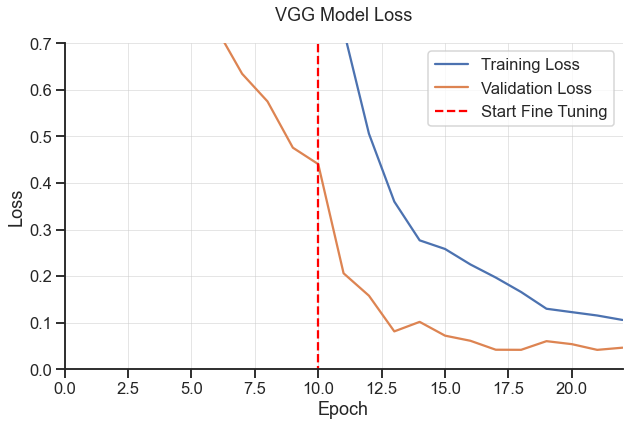

In [87]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history_vgg.history['loss'] + history_vggfine.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'] + history_vggfine.history['val_loss'], label='Validation Loss')
plt.plot([init_epochs-1,init_epochs-1], plt.ylim(), label='Start Fine Tuning',color='red',linestyle='dashed')
plt.legend(loc='upper right')
plt.title('VGG Model Loss',  y=1.05)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle='-', linewidth=0.5)
plt.ylim([0, 0.7]); plt.xlim([0, 22])
plt.show()

In [88]:
vgg_model.evaluate(test_ds)

5/5 [==============================] - 1s 70ms/step - loss: 0.0361 - accuracy: 0.9937


[0.036061424762010574, 0.9937499761581421]

In [89]:
y_pred_vgg = vgg_model.predict(x_test)
y_pred_vgg = np.apply_along_axis(transform, 1, y_pred_vgg)

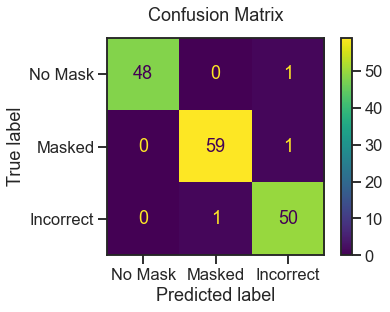

In [90]:
# Confusion matrix
confusion_matrix_plot(y_test, y_pred_vgg)

In [91]:
vgg_model_df = classification_metrics(y_pred_vgg, y_test, model_name = 'VGG Model')


Test accuracy of VGG Model: 0.981

Precision Score of VGG Model: 0.982

Recall Score of VGG Model: 0.981

f_score VGG Model: 0.981

The roc_auc of VGG Model: 0.986

Classification report:

                      precision    recall  f1-score   support

            No Mask       1.00      0.98      0.99        49
             Masked       0.98      0.98      0.98        60
MaskWearedIncorrect       0.96      0.98      0.97        51

           accuracy                           0.98       160
          macro avg       0.98      0.98      0.98       160
       weighted avg       0.98      0.98      0.98       160

Summary of classification metrics:


Model  Test Accuracy  Precision    Recall   f_score   ROC_AUC
0  VGG Model        0.98125   0.981624  0.981106  0.981299  0.985828

In [92]:
# Save the model
vgg_model.save("For CNN/Outputs/mask_detector_vgg19.h5")

## Model Comparison, Evaluation


In [93]:
df_summary = pd.DataFrame()
models=[vgg_model_df, CNN_model_df]

for df in models:
    df_summary=df_summary.append(df).reset_index().drop('index', axis=1)
df_summary

C:\Users\User\AppData\Local\Temp\ipykernel_12788\3571491755.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary=df_summary.append(df).reset_index().drop('index', axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_12788\3571491755.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary=df_summary.append(df).reset_index().drop('index', axis=1)


Model  Test Accuracy  Precision    Recall   f_score   ROC_AUC
0  VGG Model        0.98125   0.981624  0.981106  0.981299  0.985828
1  CNN Model        0.96250   0.963590  0.962212  0.962845  0.971546

In [94]:
df_summary.sort_values('Test Accuracy', ascending=False).reset_index().drop('index', axis=1) # And sort it by Test Accuracy:

Model  Test Accuracy  Precision    Recall   f_score   ROC_AUC
0  VGG Model        0.98125   0.981624  0.981106  0.981299  0.985828
1  CNN Model        0.96250   0.963590  0.962212  0.962845  0.971546

In [95]:
df_summary.set_index('Model',inplace=True)
df_summary

Test Accuracy  Precision    Recall   f_score   ROC_AUC
Model                                                            
VGG Model        0.98125   0.981624  0.981106  0.981299  0.985828
CNN Model        0.96250   0.963590  0.962212  0.962845  0.971546

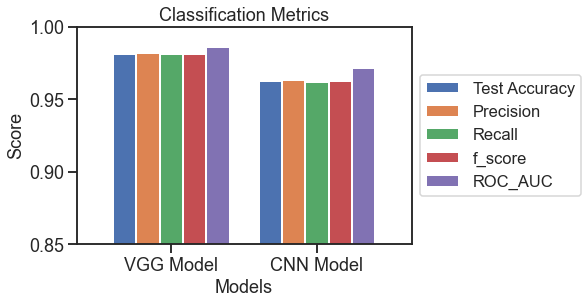

In [96]:
ax = df_summary.plot.bar(fontsize=18, xlabel='Models',
                            ylabel='Score', width=0.8,rot=0,
                            figsize=(6,4),title="Classification Metrics",alpha=1,
                            edgecolor='white', linewidth=2).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.ylim([0.85, 1]); 
#plt.xlim([0, 22])

plt.show(block=True)

# Face detection & Mask detection

In [57]:
model = keras.models.load_model("For CNN/Outputs/mask_detector_vgg19.h5")
#model = keras.models.load_model("For CNN/Outputs/cnn_model.h5")

In [58]:
from mtcnn.mtcnn import MTCNN

In [59]:
def mask_detect(img):
  sns.set_theme(style="white", palette=None)
  img_ary = img_to_array(img)
  detector = MTCNN()
  faces = detector.detect_faces(img_ary);
  plt.figure(figsize=(15, 12))
  plt.imshow(img);
  ax = plt.gca()
  for face in faces:
    x1, y1, width, height = face['box']
    x2, y2 = x1+width, y1+height

    pred = model.predict(smart_resize(img_ary[y1:y2, x1:x2], (256, 256)).reshape(1, 256, 256, 3));
    print(pred)
    if pred[0][0] >= pred[0][1] and pred[0][0] >= pred[0][2] :
      txt = 'Without Mask'
      color = 'red'
    elif pred[0][0] < pred[0][1] and pred[0][1] > pred[0][2] :
      txt = 'With Mask'
      color = 'lime'
    else:
      txt = 'MaskWearedIncorrect'
      color = 'yellow'
    
    rect = Rectangle((x1, y1), width, height, fill=False, color=color, linewidth=2)
    ax.add_patch(rect)
    ax.text(x1, y1-2, txt, fontsize=14, fontweight='bold', color=color)
  plt.show()

In [60]:
#test_path = "/content/drive/MyDrive/Colab Notebooks/DL_Project/Project_DL/1_MTCNN_Face_Mask_Detection/Test_Images"
test_path = "For CNN/Test_Images"

In [61]:
from keras.preprocessing import image

In [62]:
import glob
import cv2
images = [cv2.imread(file) for file in glob.glob(test_path+"/*")]
print('There are {} test images'.format(len(images)))

There are 3 test images


In [63]:
import cv2
#from google.colab.patches import cv2_imshow
scaled_images =[]
for img in images:
  dim = (256,256)
  #img = cv2.imread(test_path+"/maksssksksss643.png")
  #img = images[5]
  if img.shape<(256, 256):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    print('resized')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  scaled_images.append(img)

[[8.8219899e-01 7.6006650e-04 1.1704098e-01]]
[[1.5739337e-05 7.0996873e-02 9.2898732e-01]]
[[0.03055179 0.9434086  0.02603958]]
[[0.09857902 0.51313174 0.38828924]]
[[0.01066994 0.9517882  0.03754188]]
[[4.3997356e-05 9.9969542e-01 2.6062285e-04]]
[[0.08136062 0.49985614 0.4187833 ]]


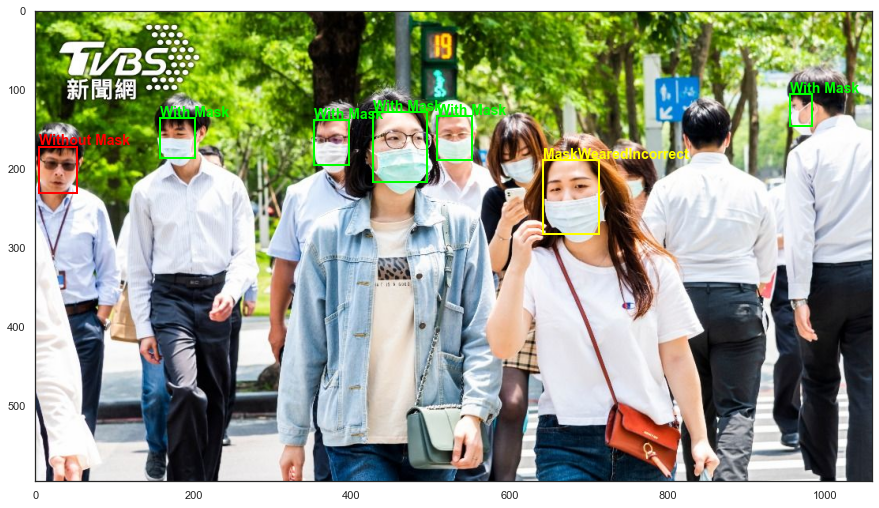

[[0.7479345  0.02125461 0.23081085]]
[[0.00104887 0.9757818  0.02316926]]
[[1.1029351e-06 9.9457437e-01 5.4245652e-03]]
[[1.9230304e-04 6.0341251e-01 3.9639518e-01]]
[[0.09557824 0.75713235 0.14728943]]
[[0.02681125 0.9262527  0.04693603]]


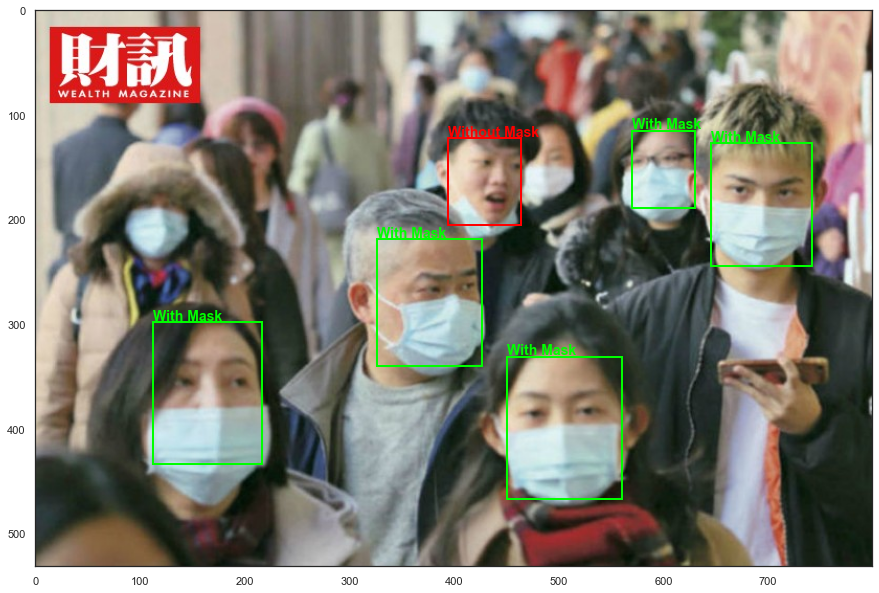

[[9.9997473e-01 2.7733117e-07 2.5032885e-05]]
[[9.307797e-02 7.806792e-05 9.068440e-01]]


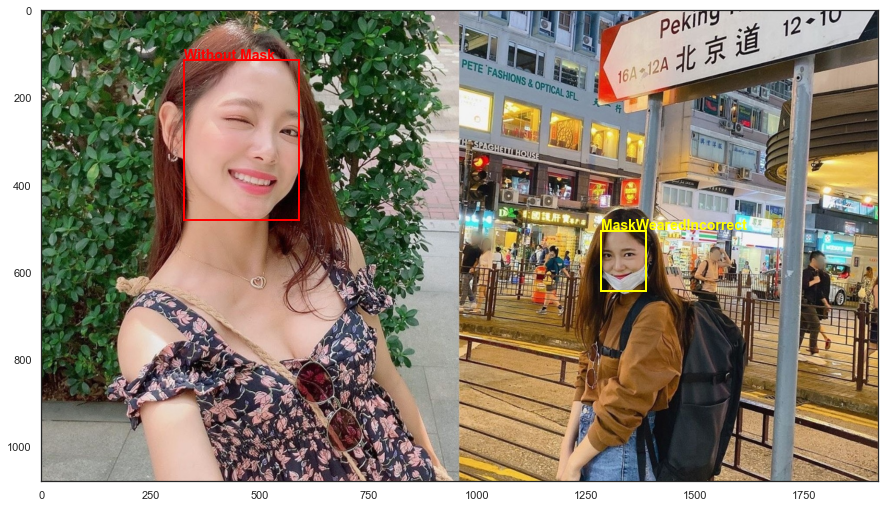

In [64]:
for image in scaled_images:
  mask_detect(image);